# 8.4 변이형 오토인코더를 사용한 이미지 생성
- **변이형 오토인코더**(Variational AutoEncoders, VAE)와 **적대적 생성 네트워크**(Generative Adversarial Networks, GAN) : 이미지의 잠재 공간에서 샘플링해서 완전히 새로운 이미지나 기존 이미지를 변형하는 방식
- 이미지에 국한되는 것이 아닌 소리, 음악, 텍스트의 잠재 공간을 만들 수 있음

## 8.4.1 이미지의 잠재 공간에서 샘플링하기
- 이미지 생성의 핵심 아이디어는 각 포인트가 실제와 같은 이미지로 매핑될 수 있는 저차원 잠재 공간(벡터 공간)의 표현을 만드는 것
- (GAE의) **생성자**(generator) 또는 (VAE의) **디코더**(decoder) : 잠재 공간의 한 포인트를 입력으로 받아 이미지를 출력하는 모듈
- VAE는 구조적인 잠재 공간을 학습하는 데 뛰어나며 이 공간에서 특정 방향은 데이터에서 의미 있는 변화의 방향을 인코딩
- GAN은 실제 같은 이미지를 만들며 여기에서 만든 잠재 공간은 구조적이거나 연속성이 없을 수 있음

## 8.4.2 이미지 변형을 위한 개념 벡터
- 잠재 공간이나 임베딩 공간이 주어지면 이 공간의 어떤 방향은 원본 데이터의 변화를 인코딩한 축일 수 있다는 **개념 벡터**(concept vector) 아이디어에서 출발
- 뉴질랜드 빅토리아 대학 디자인 스쿨의 톰 화이트는 웃음 벡터를 VAE를 통해 찾아냄

## 8.4.3 변이형 오토인코더
- 오토인코더 : 입력을 저차원 잠재 공간으로 인코딩한 후 디코딩하여 복원하는 네트워크
- 변이형 오토인코더 : 딥러닝과 베이즈 추론(Bayesian inference)의 아이디어를 혼합한 버전으로 2013년 12월 킹마와 웰링, 2014년 1월 르젠드와 무함마드, 위스트라가 발견
- 오토인코더는 입력 이미지와 동일한 이미지를 타깃 데이터로 사용하여, 원본 입력을 재구성하는 방법을 학습
    - 코딩(인코더의 출력)에 제약을 가하면 오토인코더가 더/덜 흥미로운 잠재 공간의 표현을 학습
    - 일반적으로 코딩이 저차원이고 희소하도록 제약을 가함
    - 입력 데이터의 정보를 적은 수의 비트에 압축하기 위해 노력
- 오토인코더가 특별히 유용하거나 구조화가 잘된 잠재 공간을 만들지 못하며 압축도 아주 뛰어나지 않았으나 이미지 생성을 위한 도구로써는 뛰어남
- VAE는 이미지를 어떤 통계 분포의 파라미터로 변환
    - 입력 이미지가 통계적 과정을 통해서 생성되었다고 가정하여 인코딩과 디코딩하는 동안 무작위성이 필요하다는 것을 의미
- 평균과 분산 파라미터를 사용하여 이 분포에서 무작위로 하나의 샘플을 추출, 이 샘플을 디코딩하여 원본 입력으로 복원
- 무작위한 과정이 안정성을 향상하고 잠재 공간 어디서든 의미 있는 표현을 인코딩하도록 만듦
- VAE의 작동 방식
    1. 인코더 모듈이 입력 샘플 `input_img`를 잠재 공간의 두 파라미터 `z_mean`과 `z_log_var`로 변환
        - `z_log_var = log(z_var)`으로 인코더 네트워크가 음수를 출력할 수도 있기 때문에 분산의 로그 값을 출력하도록 학습
    2. 입력 이미지가 생성되었다고 가정한 잠재 공간의 정규 분포에서 포인트 `z`를 `z = z_mean + exp(0.5 * z_log_var) * epsilon`처럼 무작위로 샘플링
        - `epsilon`은 작은 값을 가진 랜덤 텐서
    3. 디코더 모듈은 잠재 공간의 이 포인트를 원본 입력 이미지로 매핑하여 복원
- 잠재 공간에서 가까운 2개의 포인트는 아주 비슷한 이미지로 디코딩될 것이며 이런 저차원 연속성은 잠재 공간에서 모든 방향이 의미 있는 데이터 변화의 축을 인코딩하도록 만들고, 결국 잠재 공간은 매우 구조적이고 개념 벡터로 다루기에 적합해짐
- VAE는 2개의 손실 함수로 훈련 : **재구성 손실**(reconstruction loss)과 **규제 손실**(regularization loss)
    - 재구성 손실 : 디코딩된 샘플이 원본 입력과 동일하도록 만듦
    - 규제 손실 : 잠재 공간을 잘 형성하고 훈련 데이터에 과대적합을 줄임
    
```python
z_mean, z_log_var = encoder(input_img) # 입력을 평균과 분산 파라미터로 인코딩

z = z_mean + exp(0.5 * z_log_var) * epsilon # 무작위로 선택한 작은 epsilon 값을 사용하여 잠재 공간의 포인트를 뽑음

reconstructed_img = decoder(z) # z를 이미지로 디코딩

model = Model(input_img, reconstructed_img) # 입력 이미지와 재구성 이미지를 매핑한 오토인코더 모델 객체를 만듦
```

### VAE 인코더 네트워크
- 이미지를 잠재 공간상 확률 분포 파라미터로 매핑하는 인코더 네트워크
- 입력 이미지 x를 두 벡터 `z_mean`과 `z_log_var`로 매핑하는 간단한 컨브넷
- `K.int_shape()` : 텐서의 크기를 파이썬 튜플로 반환하는 함수

In [1]:
import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2 # 잠재 공간의 차원 : 2D 평면

input_img = tf.keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# 입력 이미지는 결국 2개의 파라미터로 인코딩됨
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

### 잠재 공간 샘플링 함수
- `z_mean`, `z_log_var` 파라미터가 `input_img`를 생성한 통계 분포의 파라미터라 가정하고 잠재 공간 포인트 `z` 생성
- 케라스의 백엔드 기능으로 만든 일련의 코드를 `Lambda` 층으로 감쌈
    - 케라스에서는 모든 것이 층이므로 기본 층을 사용하지 않은 코드는 `Lambda`로 (또는 직접 만든 층으로) 감싸야 함
    - `layers.Lambda` 클래스는 임의의 함수 객체를 케라스의 층으로 만들어 줌

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

### 잠재 공간 포인트를 이미지로 매핑하는 VAE 디코더 네트워크
- 벡터 `z`를 이전 특성 맵 차원으로 크기를 바꾸고 몇 개의 합성곱 층을 사용하여 최종 출력 이미지 생성
- `Conv2DTranspose` 층 : 입력 값 사이에 0을 추가하여 출력을 업샘플링하는 전치 합성곱을 수행

In [4]:
shape_before_flattening

(None, 14, 14, 64)

In [5]:
decoder_input = layers.Input(K.int_shape(z)[1:]) # input에 z를 주입

# 입력을 업샘플링
# shape_before_flattening 크기를 복원해야 함
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 인코더 모델의 마지막 Flatten 층 직전의 특성 맵과 같은 크기를 가진 특성 맵으로 z의 크기를 바꿈
x = layers.Reshape(shape_before_flattening[1:])(x)

# Conv2DTranspose 층과 Conv2D 층을 사용하여 z를 원본 입력 이미지와 같은 크기의 특성 맵으로 디코딩
x = layers.Conv2DTranspose(32, 3, 
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# decoder_input을 디코딩된 이미지로 변환하는 디코더 모델의 객체 생성
decoder = Model(decoder_input, x)

z_decoded = decoder(z) # 모델에 z를 주입하면 디코딩된 z를 출력

In [6]:
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


### VAE 손실을 계산하기 위해 직접 만든 층
- 일반적인 샘플 기준의 함수인 `loss(y_true, y_pred)` 형태는 VAE의 이중 손실에 맞지 않음
- `add_loss` 내장 메서드를 사용하는 층을 직접 만들어 임의의 손실을 정의
    - `Layer` 클래스의 `add_loss()` 메서드를 사용하여 추가된 손실은 `vae.losses` 파이썬 리스트에서 확인할 수 있으며 `kl_loss` 계산식의 상수 값이 원래 0.5이지만 여기서는 규제 손실의 양을 조절하기 위해 0.0005 사용

In [7]:
class CustomVariationalLayer(tf.keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    # call 메서드가 있는 층 구현
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x # 이 출력을 사용하지는 않지만 층은 무언가를 반환해야 함(Model 객체를 만들기 위해서 마지막 층에서 출력된 텐서가 있어야 함)
    
# 입력과 디코딩된 출력으로 이 층을 호출하여 모델의 최종 출력을 얻음
y = CustomVariationalLayer()([input_img, z_decoded])

### VAE 훈련하기
- 층에서 손실을 직접 다루기 때문에 `compile` 메서드에서 손실을 지정하지 않음
- 훈련하는 동안 타깃 데이터를 전달하지 않아도 됨

In [8]:
from tensorflow.keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

C:\Users\master\anaconda3\envs\multi\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 46s 759us/sample - loss: 0.3559 - val_loss: 0.1980
Epoch 2/10
60000/60000 [==============================] - 36s 604us/sample - loss: 0.1957 - val_loss: 0.1925
Epoch 3/10
60000/60000 [==============================] - 36s 607us/sample - loss: 0.1918 - val_loss: 0.1913
Epoch 4/10
60000/60000 [==============================] - 37s 609us/sample - loss: 0.1894 - val_loss: 0.1885
Epoch 5/10
60000/60000 [==============================] - 36s 602us/sample - loss: 0.1876 - val_loss: 0.1867
Epoch 6/10
60000/60000 [==============================] - 36s 602us/sample - loss: 0.1862 - val_loss: 0.1857
Epoch 7/10
60000/60000 [==============================] - 37s 616us/sample - loss: 0.1852 - val_loss: 0.1860
Epoch 8/10
60000/60000 [==============================] - 36s 608us/sample - loss: 0.1843 - val_loss: 0.1845
Epoch 9/10
60000/60000 [==============================] - 37s 614us/sample - loss: 0.1835 - val_loss: 0.1833
Epoch 10/10
60000/60000 [=====

### 2D 잠재 공간에서 포인트 그리드를 샘플링하여 이미지로 디코딩하기

C:\Users\master\anaconda3\envs\multi\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


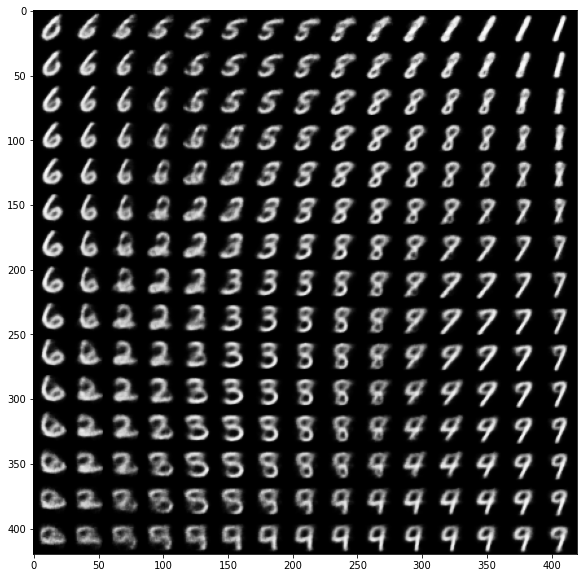

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15  # 15x15 숫자의 그리드를 출력
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# scipy의 ppf 함수를 사용하여 일정하게 떨어진 간격마다 잠재 변수 z의 값을 생성
# 잠재 공간의 사전 확률은 가우시안 (백분위수를 입력하면 해당 포인트 값을 반환)
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        
        # z를 여러 번 반복하여 완전한 배치를 만듦
        # np.tile() 함수는 입력 값을 반복하여 늘림
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        # 배치를 숫자 이미지로 디코딩
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        # 배치의 첫 번째 숫자 크기를 28x28x1에서 28x28로 바꿈
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

- 이 공간에서 특정 방향은 어떤 의미를 가짐(6으로 가는 방향, 9로 가는 방향 등)